# ランダムフォレストのデモプログラム

ランダムフォレストのデモプログラムです。  
ランダムフォレストの中身に関してはこちら↓で解説しています。  
https://yuyumoyuyu.com/2021/02/21/ensembledecisiontree/

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.figure as figure
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

import time

%matplotlib inline

# クラス分類

### 決定木との比較

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.datasets import make_moons

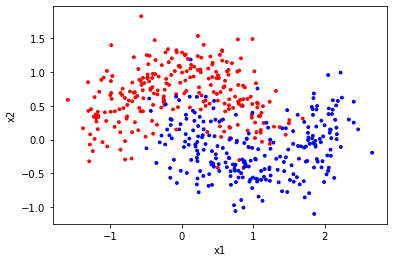

In [3]:
# sklearnのデータセットを用いる

X, y = make_moons(n_samples=500, noise=0.3, random_state=6)

plt.figure()

cmap = ListedColormap(('red', 'blue'))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, cmap=cmap, s=8)

plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

In [4]:
# 入力データは2次元の座標データ
print("X =\n", X[:10])

X =
 [[ 1.05769609e-01  1.42222019e-02]
 [-6.69715288e-01  6.91297509e-01]
 [-1.20374501e+00  3.70471637e-01]
 [ 2.40648591e+00  5.59849147e-01]
 [ 1.07922887e+00  3.46245244e-01]
 [ 1.95305802e+00  2.78931158e-01]
 [ 1.15826758e+00 -4.38060183e-01]
 [ 6.66709932e-01 -2.39615329e-03]
 [-6.55169079e-01  2.55762239e-01]
 [ 1.42811074e+00 -3.32526975e-01]]


In [5]:
# 学習データをtrain/test分割
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

In [6]:
# 分類木の学習
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.933
Accuracy on test set: 0.904


In [7]:
# ランダムフォレスト分類器の学習

rfc = RFC(max_depth=5, n_estimators=10, random_state=0)
rfc.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(rfc.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))

Accuracy on training set: 0.933
Accuracy on test set: 0.928


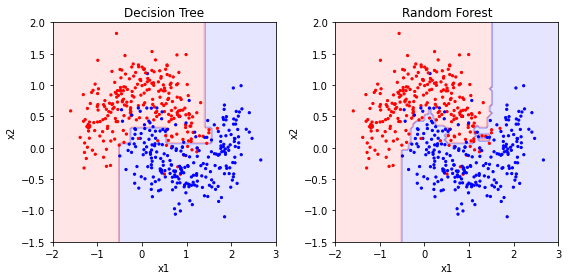

In [8]:
# 学習結果を可視化
x1 = np.linspace(-2.0, 3.0, 100)
x2 = np.linspace(-1.5, 2.0, 100)
x1_mesh, x2_mesh = np.meshgrid(x1, x2)    

z1 = tree.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
z1 = z1.reshape(x1_mesh.shape)
z2 = rfc.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
z2 = z2.reshape(x1_mesh.shape)

z_list = [z1, z2]
titles = ['Decision Tree', 'Random Forest']

fig, axes = plt.subplots(1, 2, figsize=(8,4))

for ax, z, title in zip(axes, z_list, titles):
    ax.contourf(x1_mesh, x2_mesh, z, cmap=cmap, alpha=0.1, linestyles=None)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=y, cmap=cmap, s=5)

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

    ax.set_title(title)

fig.tight_layout()

アンサンブル学習により，高精度な分類が可能に

### ハイパーパラメータ最適化

In [9]:
from sklearn.datasets import load_iris

In [10]:
# Irisデータセットを用いる
iris = load_iris()

# 学習データをtrain/test分割
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(iris.data,
                                                            iris.target,
                                                            stratify=iris.target,
                                                            random_state=0)

In [11]:
# グリッドサーチによるハイパーパラメータ最適化
t1 = time.time()

print("RFC\n")
params = {
          'max_depth': [2,3,5,10],            # treeの深さの最大値
          'max_features': [1,3,'auto'],       # treeの構築に使用する特徴量の数
          'min_samples_split': [2,3,5],       # ノード分割に必要な最小サンプルサイズ
          'min_samples_leaf': [1,3,5],        # 葉を構成するのに必要な最低サンプル数
          'n_estimators': [10,30,50,100,300]  # treeの数
          }

print("parameters:  \n{}\n".format(params))

grid_search = GridSearchCV(RFC(), params, cv=5, return_train_score=True)
grid_search.fit(X_train_i, y_train_i)

print("best parameters: {}".format(grid_search.best_params_))
print("best cross-validation score: {:.3f}".format(grid_search.best_score_))

print("\nelapsed time: {:.3f} sec".format(time.time()-t1))

RFC

parameters:  
{'max_depth': [2, 3, 5, 10], 'max_features': [1, 3, 'auto'], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 3, 5], 'n_estimators': [10, 30, 50, 100, 300]}

best parameters: {'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}
best cross-validation score: 0.964

elapsed time: 287.895 sec


In [12]:
rfc = RFC(**grid_search.best_params_).fit(X_train_i, y_train_i)

print("==Training set==")
print("Score: {:.3f}".format(rfc.score(X_train_i, y_train_i)))
print("Confusion matrix:\n", confusion_matrix(y_train_i,rfc.predict(X_train_i),labels=sorted(set(y_train_i))))

print("\n==Test set==")
print("Score: {:.3f}".format(rfc.score(X_test_i, y_test_i)))
print("Confusion matrix:\n", confusion_matrix(y_test_i,rfc.predict(X_test_i),labels=sorted(set(y_test_i))))

==Training set==
Score: 0.955
Confusion matrix:
 [[37  0  0]
 [ 0 35  2]
 [ 0  3 35]]

==Test set==
Score: 0.974
Confusion matrix:
 [[13  0  0]
 [ 0 13  0]
 [ 0  1 11]]


# 回帰木

In [13]:
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.datasets import load_boston

In [14]:
# Bostonデータセットを用いる
boston = load_boston()

# 学習データをtrain/test分割
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(boston.data,
                                                            boston.target,
                                                            random_state=0)

In [15]:
# グリッドサーチによるハイパーパラメータ最適化
t1 = time.time()

print("RFR\n")
params = {
          'max_depth': [10,20,30],            # treeの深さの最大値
          'max_features': [3,5,10,'auto'],       # treeの構築に使用する特徴量の数
          'min_samples_split': [2,3,5],       # ノード分割に必要な最小サンプルサイズ
          'min_samples_leaf': [1,3,5],        # 葉を構成するのに必要な最低サンプル数
          'n_estimators': [10,30,50,100]  # treeの数
          }

print("parameters:  \n{}\n".format(params))

grid_search = GridSearchCV(RFR(), params, cv=5, return_train_score=True)
grid_search.fit(X_train_b, y_train_b)

print("best parameters: {}".format(grid_search.best_params_))
print("best cross-validation score: {:.3f}".format(grid_search.best_score_))

print("\nelapsed time: {:.3f} sec".format(time.time()-t1))

RFR

parameters:  
{'max_depth': [10, 20, 30], 'max_features': [3, 5, 10, 'auto'], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 3, 5], 'n_estimators': [10, 30, 50, 100]}

best parameters: {'max_depth': 20, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
best cross-validation score: 0.880

elapsed time: 145.429 sec


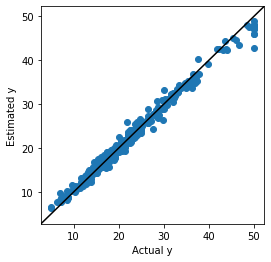

  Training set score: 0.986


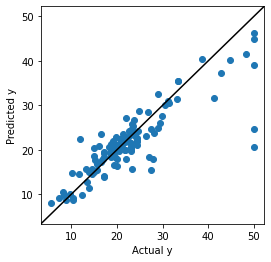

  Test set score: 0.719


In [16]:
# 可視化
rfr = RFR(**grid_search.best_params_).fit(X_train_b, y_train_b)

# trainデータ
y_train_est = rfr.predict(X_train_b)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_train_b, y_train_est)
y_max = max( y_train_b.max(), y_train_est.max() )
y_min = min( y_train_b.min(), y_train_est.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Estimated y')
plt.show()
print("  Training set score: {:.3f}".format(rfr.score(X_train_b, y_train_b))) 

# testデータ
y_test_pred = rfr.predict(X_test_b)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_test_b, y_test_pred)
y_max = max( y_test_b.max(), y_test_pred.max() )
y_min = min( y_test_b.min(), y_test_pred.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()
print("  Test set score: {:.3f}".format(rfr.score(X_test_b, y_test_b)))
